### 1. Import dependencies

In [ ]:
from pathlib import Path
import numpy as np
import os
from zipfile import ZipFile
import h5py
import matplotlib.pyplot as plt
from PIL import Image
import random
from tqdm.auto import tqdm
from timeit import default_timer as timer
import cv2

import torch
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader, random_split
import torchvision
from torchvision import transforms

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

### 2. Load, Preprocess, and Split data

**Dataset:** https://figshare.com/articles/brain_tumor_dataset/1512427

In [ ]:
# Create paths
drive_path = Path('drive/MyDrive/Datasets')
data_path = Path('data')
data_path.mkdir(exist_ok=True, parents=True)

In [ ]:
# Extract data
zip_files = ['brainTumorDataPublic_22993064.zip', 'brainTumorDataPublic_7671532.zip', 'brainTumorDataPublic_15332298.zip', 'brainTumorDataPublic_1766.zip']

for zip in zip_files:
    with ZipFile(drive_path/zip, 'r') as zip:
        zip.extractall(data_path)

In [ ]:
data_count = len(os.listdir(str(data_path)))
data_count

3064

In [ ]:
# Test read MAT file
file = h5py.File(name=data_path/'3.mat', mode='r').get('cjdata')
file.keys()

<KeysViewHDF5 ['PID', 'image', 'label', 'tumorBorder', 'tumorMask']>

In [ ]:
file.get('image')[:].dtype

dtype('int16')

In [ ]:
img_data, mask_data = [], []

img_idxs = range(data_count)
for idx in img_idxs:
    # Read each MAT file to get image and mask
    file = h5py.File(name=f'{str(data_path)}/{idx+1}.mat', mode='r').get('cjdata')
    # np array image and masks for given sample
    image = file.get('image')[:]
    epsilon = 4e-3
    image = (image.astype(np.float32) / 65535) + epsilon # scale int16
    mask = file.get('tumorMask')[:]

    # Preprocess image
    image = Image.fromarray(image).resize((128, 128))
    image = transforms.functional.pil_to_tensor(image)

    # can't apply ToTensor due to image and mask number ranges
    mask = Image.fromarray(mask).convert('L').resize((128, 128))
    mask = transforms.functional.pil_to_tensor(mask)

    img_data.append(image)
    mask_data.append(mask)

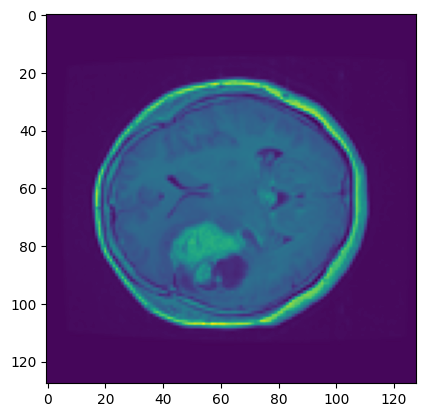

In [ ]:
plt.imshow(img_data[4][0])

In [ ]:
img_data = torch.stack(img_data)
mask_data = torch.stack(mask_data).type(torch.float)
img_data.shape, mask_data.shape

(torch.Size([3064, 1, 128, 128]), torch.Size([3064, 1, 128, 128]))

In [ ]:
# Create dataset object and Split data
def create_split_datasets(img_data, mask_data, train_split: int=0.8):
    dataset = TensorDataset(img_data, mask_data)

    train_size = int(len(dataset) * train_split)
    val_size = int((len(dataset) - train_size)/2)
    test_size = len(dataset) - train_size - val_size

    torch.manual_seed(24)
    train_data, val_data, test_data = random_split(dataset=dataset, lengths=[train_size, val_size, test_size])
    return train_data, val_data, test_data

train_data, val_data, test_data = create_split_datasets(img_data, mask_data)

In [ ]:
print(f'Shape: image - {train_data[0][0].shape} mask - {train_data[0][1].shape}')
print(f'Split (train, val, test): {len(train_data)}, {len(val_data)}, {len(test_data)}')

Shape: image - torch.Size([1, 128, 128]) mask - torch.Size([1, 128, 128])
Split (train, val, test): 2451, 306, 307


In [ ]:
# Create dataloader
BATCH_SIZE = 8
NUM_WORKERS = os.cpu_count()

torch.manual_seed(24)
train_dl = DataLoader(dataset=train_data,
                      batch_size=BATCH_SIZE,
                      num_workers=NUM_WORKERS,
                      shuffle=True)

val_dl = DataLoader(dataset=val_data,
                      batch_size=BATCH_SIZE,
                      num_workers=NUM_WORKERS)

test_dl = DataLoader(dataset=test_data,
                      batch_size=BATCH_SIZE,
                      num_workers=NUM_WORKERS)

print(f'Train: {len(train_dl)} batches of {train_dl.batch_size}')
print(f'Val: {len(val_dl)} batches of {val_dl.batch_size}')
print(f'Test: {len(test_dl)} batches of {test_dl.batch_size}')

Train: 307 batches of 8
Val: 39 batches of 8
Test: 39 batches of 8


In [ ]:
image, mask = next(iter(train_dl))
image.shape, mask.shape

(torch.Size([8, 1, 128, 128]), torch.Size([8, 1, 128, 128]))

### 3. Examine images

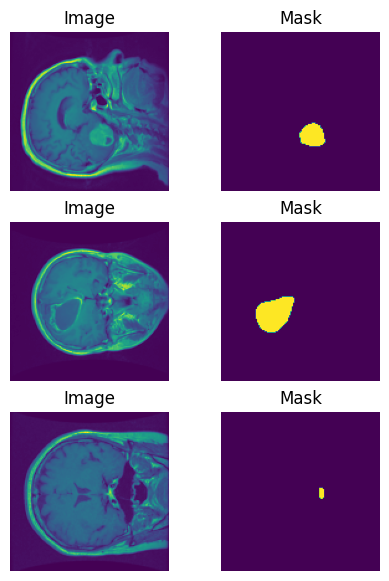

In [ ]:
def plot_random_images(dataset: torch.utils.data.Dataset, n: int, seed: int=None):
    if seed:
        random.seed(None)
    if n > 5:
        n = 5
        print('n exceeds maximum: setting n to 5')

    data_range = range(len(dataset))
    selected_idxs = random.sample(data_range, k=n)
    plt.figure(figsize=(5, 7))

    for i, idx in enumerate(selected_idxs):
        plt.subplot(3, 2, 2*i+1)
        plt.title('Image')
        plt.axis(False)
        image, mask = dataset[idx][0].squeeze(0), dataset[idx][1].squeeze(0)
        plt.imshow(image)

        plt.subplot(3, 2, 2*i+2)
        plt.title('Mask')
        plt.axis(False)
        plt.imshow(mask)

plot_random_images(dataset=train_data, n=3)

### 4. Build U-Net model

In [ ]:
class ConvBlocks(nn.Module):
    def __init__(self, n_convs, in_channels, out_channels, kernel_size=3, stride=1, padding=0):
        super().__init__()
        self.layers = nn.ModuleList() # list for multiple layers

        # instantiate multiple blocks
        for conv in range(n_convs):
            conv_block = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
                nn.BatchNorm2d(num_features=out_channels, eps=1e-05, momentum=0.1),
                nn.ReLU(inplace=True)
            )
            in_channels = out_channels
            self.layers.append(conv_block)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        for layer in self.layers:
            x = layer(x)
        return x

In [ ]:
class Encoder(nn.Module):
    def __init__(self, n_blocks, in_channels, out_channels, padding):
        super().__init__()
        self.enc_layers = nn.ModuleList()
        for blk in range(n_blocks):
            # creates and appends an encoder block
            self.enc_layers += [
                ConvBlocks(n_convs=2, in_channels=in_channels, out_channels=out_channels, padding=padding),
                nn.MaxPool2d(kernel_size=2)
            ]
            # channels double for each encoder block (maxpool)
            in_channels = out_channels
            out_channels *= 2

        # last encoder layer has no maxpool, keep channels same
        self.enc_layers.append(ConvBlocks(2, in_channels, in_channels, padding))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        skip_connections = []
        for layer in self.enc_layers:
            x = layer(x)
            # copy outputs of each CNN layer
            if isinstance(layer, ConvBlocks):
                skip_connections.append(x)
        return x, skip_connections

In [ ]:
# Test encoding block
enc_layers = nn.ModuleList()
enc_layers += [
    ConvBlocks(n_convs=2, in_channels=1, out_channels=10, padding=1),
    nn.MaxPool2d(kernel_size=2)
]
output = enc_layers[0](train_data[0][0].unsqueeze(dim=0))
output = enc_layers[1](output)
output.shape

torch.Size([1, 10, 64, 64])

In [ ]:
class Decoder(nn.Module):
    def __init__(self, n_blocks, in_channels, out_channels, exit_channels, padding):
        super().__init__()
        self.layers = nn.ModuleList()
        for blk in range(n_blocks):
            self.layers += [
                # keep in-channels for upsample and then double in and out channels for concat of skip connections
                nn.ConvTranspose2d(in_channels=in_channels, out_channels=in_channels, kernel_size=2, stride=2),
                ConvBlocks(n_convs=2, in_channels=in_channels * 2, out_channels=out_channels, padding=padding)
            ]
            in_channels = out_channels
            out_channels //= 2
        self.layers.append(
            nn.Conv2d(in_channels, exit_channels, kernel_size=1, stride=1, padding=0)
        )

    def forward(self, x: torch.Tensor, skip_connections: torch.Tensor) -> torch.Tensor:
        skip_connections.pop(-1) # remove asymmetrical last conv output
        for layer in self.layers:
            if isinstance(layer, ConvBlocks):
                skip_connections[-1] = transforms.functional.center_crop(skip_connections[-1], x.shape[2])
                x = torch.cat([x, skip_connections.pop(-1)], dim=1)
            x = layer(x)
        return x

In [ ]:
class UNet(nn.Module):
    '''U-Net class creates a flexible number of encoder-decoder blocks for semantic segmentation

    Args
    - n_blocks (int): number of blocks for encoder and decoder blocks
    - in_channels (int): number of channels in initial input layer
    - first_out_channels (int): number of channels in first convolutional layer
    - exit_channels (int): number of output channels in final layer
    - padding (int): padding for encoder-decoder convolutional layers
    '''
    def __init__(self,
                 n_blocks: int,
                 in_channels: int,
                 first_out_channels: int,
                 exit_channels: int,
                 padding: int):
        super().__init__()
        self.encoder = Encoder(n_blocks=n_blocks, in_channels=in_channels, out_channels=first_out_channels, padding=padding)

        # decoder in-channels is derived by doubling initial channels 'n_block' times
        self.dec_in_channels = first_out_channels * 2**(n_blocks-1)
        self.decoder = Decoder(n_blocks=n_blocks, in_channels=self.dec_in_channels, out_channels=self.dec_in_channels//2,
                               exit_channels=exit_channels, padding=padding)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x, skip_connections = self.encoder(x)
        return self.decoder(x, skip_connections)

In [ ]:
model = UNet(n_blocks=2, in_channels=1, first_out_channels=10, exit_channels=1, padding=1)
model.to(device)

try:
    import torchinfo
except:
    !pip install torchinfo

from torchinfo import summary
summary(model, input_size=(8, 1, 128, 128), col_names=['input_size', 'output_size', 'num_params'])

Layer (type:depth-idx)                             Input Shape               Output Shape              Param #
UNet                                               [8, 1, 128, 128]          [8, 1, 128, 128]          --
├─Encoder: 1-1                                     [8, 1, 128, 128]          [8, 20, 32, 32]           --
│    └─ModuleList: 2-1                             --                        --                        --
│    │    └─ConvBlocks: 3-1                        [8, 1, 128, 128]          [8, 10, 128, 128]         1,050
│    │    └─MaxPool2d: 3-2                         [8, 10, 128, 128]         [8, 10, 64, 64]           --
│    │    └─ConvBlocks: 3-3                        [8, 10, 64, 64]           [8, 20, 64, 64]           5,520
│    │    └─MaxPool2d: 3-4                         [8, 20, 64, 64]           [8, 20, 32, 32]           --
│    │    └─ConvBlocks: 3-5                        [8, 20, 32, 32]           [8, 20, 32, 32]           920
├─Decoder: 1-2                    

In [ ]:
test_inference = model(train_data[0][0].unsqueeze(0).to(device))
test_inference.shape

torch.Size([1, 1, 128, 128])

### 5. Train Model

In [ ]:
try:
    import torchmetrics
except:
    !pip install -qq torchmetrics
from torchmetrics import Precision, Recall, F1Score

precision_fn = Precision(task='binary').to(device)
recall_fn = Recall(task='binary').to(device)
f1_score_fn = F1Score(task='binary').to(device)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 866.2/866.2 kB 20.4 MB/s eta 0:00:00


In [ ]:
def train_step(model: torch.nn.Module, train_dl: torch.utils.data.DataLoader, loss_fn: torch.nn.Module, optimizer, f1_score_fn, l2_lambda: int=None, device: torch.device='cpu'):
    train_loss, train_f1 = 0, 0
    for b, (b_images, b_masks) in enumerate(train_dl):
        b_images, b_masks = b_images.to(device), b_masks.to(device)
        model.train()
        y_logits = model(b_images)
        loss = loss_fn(y_logits, b_masks)

        # L2 Regularization
        if l2_lambda:
            l2_norm = sum(w.pow(2).sum() for w in model.parameters())
            loss += l2_lambda * l2_norm

        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        y_preds = torch.sigmoid(y_logits).round().type(torch.int)
        train_f1 = f1_score_fn(y_preds, b_masks)
        if b % (len(train_dl) // 3) == 0:
            print(f'Examined {(b+1) * train_dl.batch_size}/{len(train_dl.dataset)} images')

    train_loss /= len(train_dl)

    return train_loss, train_f1


In [ ]:
def val_step(model: torch.nn.Module, val_dl: torch.utils.data.DataLoader, loss_fn: torch.nn.Module, f1_score_fn, l2_lambda: int=None, device: torch.device='cpu'):
    model.eval()
    val_loss = 0
    with torch.inference_mode():
        for b_images, b_masks in val_dl:
            b_images, b_masks = b_images.to(device), b_masks.to(device)
            y_logits = model(b_images)
            loss = loss_fn(y_logits, b_masks)

            if l2_lambda:
                l2_norm = sum(w.pow(2).sum() for w in model.parameters())
                loss += l2_lambda * l2_norm
            val_loss += loss.item()

            y_preds = torch.sigmoid(y_logits).round().type(torch.int)
            val_f1 = f1_score_fn(y_preds, b_masks)

        val_loss /= len(val_dl)

    return val_loss, val_f1

In [ ]:
def train(model: torch.nn.Module,
          epochs: int, train_dl: torch.utils.data.DataLoader,
          val_dl: torch.utils.data.DataLoader,
          loss_fn: torch.nn.Module, optimizer,
          f1_score_fn,
          l2_lambda: int=None,
          device: torch.device='cpu',
          seed: int=None):
    if seed:
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)

    results = {'train_loss': [],
               'train_f1': [],
               'val_loss': [],
               'val_f1': []}

    model.to(device)
    f1_score_fn.to(device)
    for epoch in tqdm(range(epochs)):
        print(f'Epoch {epoch}\n------')
        train_loss, train_f1 = train_step(model, train_dl, loss_fn, optimizer, f1_score_fn, l2_lambda, device)
        val_loss, val_f1 = val_step(model, val_dl, loss_fn, f1_score_fn, l2_lambda, device)

        results['train_loss'].append(train_loss)
        results['train_f1'].append(train_f1)
        results['val_loss'].append(val_loss)
        results['val_f1'].append(val_f1)
        print(f'Train loss {train_loss: .4f} | Train F1 score {train_f1: .4f} | Validation loss {val_loss: .4f} | Validation F1 score {val_f1}')

    return results

In [ ]:
EPOCHS = 40
lr = 0.01
l2_lambda = 0.001
momentum = 0.9

loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(params=model.parameters(), lr=lr, momentum=momentum)

start = timer()
results = train(model=model,
                epochs = EPOCHS,
                train_dl=train_dl,
                val_dl=val_dl,
                loss_fn=loss_fn,
                optimizer=optimizer,
                f1_score_fn=f1_score_fn,
                l2_lambda=l2_lambda,
                seed=24)
print(f'<< Train time: {timer() - start} >>')

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 0
------
Examined 8/2451 images
Examined 824/2451 images
Examined 1640/2451 images
Examined 2456/2451 images
Train loss  0.3188 | Train F1 score  0.0000 | Validation loss  0.2472 | Validation F1 score 0.0
Epoch 1
------
Examined 8/2451 images
Examined 824/2451 images
Examined 1640/2451 images
Examined 2456/2451 images
Train loss  0.2376 | Train F1 score  0.0000 | Validation loss  0.2265 | Validation F1 score 0.0
Epoch 2
------
Examined 8/2451 images
Examined 824/2451 images
Examined 1640/2451 images
Examined 2456/2451 images
Train loss  0.2180 | Train F1 score  0.0000 | Validation loss  0.2109 | Validation F1 score 0.0
Epoch 3
------
Examined 8/2451 images
Examined 824/2451 images
Examined 1640/2451 images
Examined 2456/2451 images
Train loss  0.1996 | Train F1 score  0.0000 | Validation loss  0.1935 | Validation F1 score 0.0
Epoch 4
------
Examined 8/2451 images
Examined 824/2451 images
Examined 1640/2451 images
Examined 2456/2451 images
Train loss  0.1831 | Train F1 score  0.00

### 6. Save and Reload model

In [ ]:
model_path = Path('models')
model_name = 'tumor_seg_model.pt'
model_path.mkdir(exist_ok=True, parents=True)

def save_model(model: torch.nn.Module,
               results: dict,
               model_path,
               model_name: str):
    torch.save(
        {'model': model.state_dict(),
        'results': results},
        f=model_path/model_name
    )

def load_model(model_path, model_name):
    model_2 = UNet(n_blocks=2, in_channels=1, first_out_channels=10, exit_channels=1, padding=1)
    load_dict = torch.load(model_path/model_name)
    model_2.load_state_dict(load_dict['model'])
    return load_dict, model_2

save_model(model, results, model_path, model_name)
load_dict, model_2 = load_model(model_path, model_name)

<ipython-input-20-ca6c3efa4969>:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  load_dict = torch.load(model_path/model_name)


In [ ]:
load_dict['results']

{'train_loss': [0.3187601654653829,
  0.23761914573391407,
  0.21795718978592937,
  0.19961256240206354,
  0.18305224568525433,
  0.16888744211740525,
  0.15626052240401214,
  0.1458317911440464,
  0.13608582934261534,
  0.12697946044831787,
  0.11926443423432713,
  0.11250467712502527,
  0.10688797032600117,
  0.10125741913477838,
  0.09593486929075726,
  0.09155051245169064,
  0.0879370794428288,
  0.08451332387299025,
  0.08201197847869575,
  0.07848968379903305,
  0.07623167635709144,
  0.07494360715733289,
  0.07255769113278933,
  0.07090141301434669,
  0.06895407597482787,
  0.06748894609341016,
  0.06618168160125176,
  0.06527707621406655,
  0.06426429474295545,
  0.062403906561458534,
  0.06220591524524875,
  0.06094774933901983,
  0.06009880227646532,
  0.05954524292231383,
  0.05891531813853339,
  0.0582836432934584,
  0.058078078716896256,
  0.057431892276489774,
  0.05736593272330707,
  0.057261035076861276],
 'train_f1': [tensor(0.),
  tensor(0.),
  tensor(0.),
  tensor(0.

### 7. Evaluate model and training

In [ ]:
# Evaluate model on test data
model_2.eval()
test_loss, test_f1 = 0, 0
with torch.inference_mode():
    for b_images, b_masks in test_dl:
        y_logits = model_2(b_images)
        test_loss += loss_fn(y_logits, b_masks).item()
        y_preds = y_logits.sigmoid().round()
        test_f1 += f1_score_fn(y_preds, b_masks).item()
test_loss /= len(test_dl)
test_f1 /= len(test_dl)
print(f'Test loss {test_loss} | Test f1 {test_f1}')

Test loss 0.05469154499662228 | Test f1 0.4964663218229245


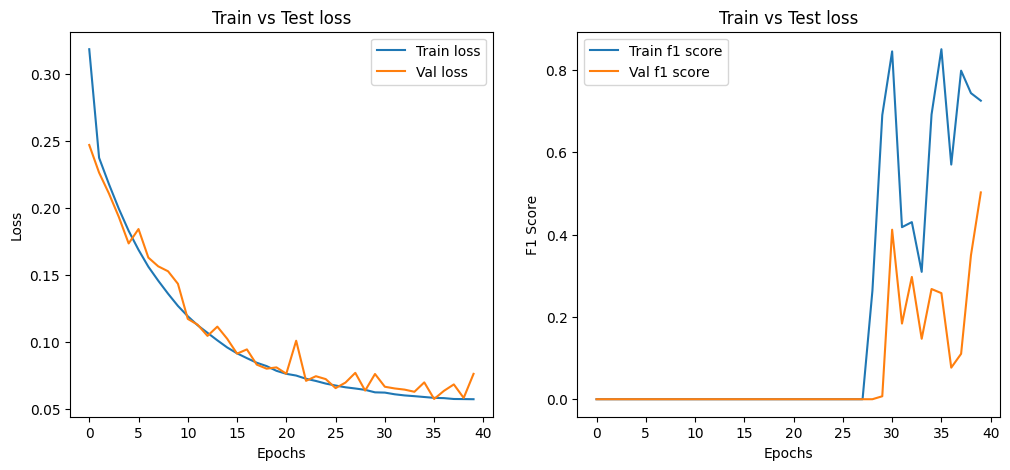

In [ ]:
def plot_train_results(results, epochs: int):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(epochs), results['train_loss'], label='Train loss')
    plt.plot(range(epochs), results['val_loss'], label='Val loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Train vs Test loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(epochs), results['train_f1'], label='Train f1 score')
    plt.plot(range(epochs), results['val_f1'], label='Val f1 score')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.title('Train vs Test F1')
    plt.legend()

plot_train_results(results=load_dict['results'], epochs=EPOCHS)

#### Plot predictions with Postprocessing (morphological operations)

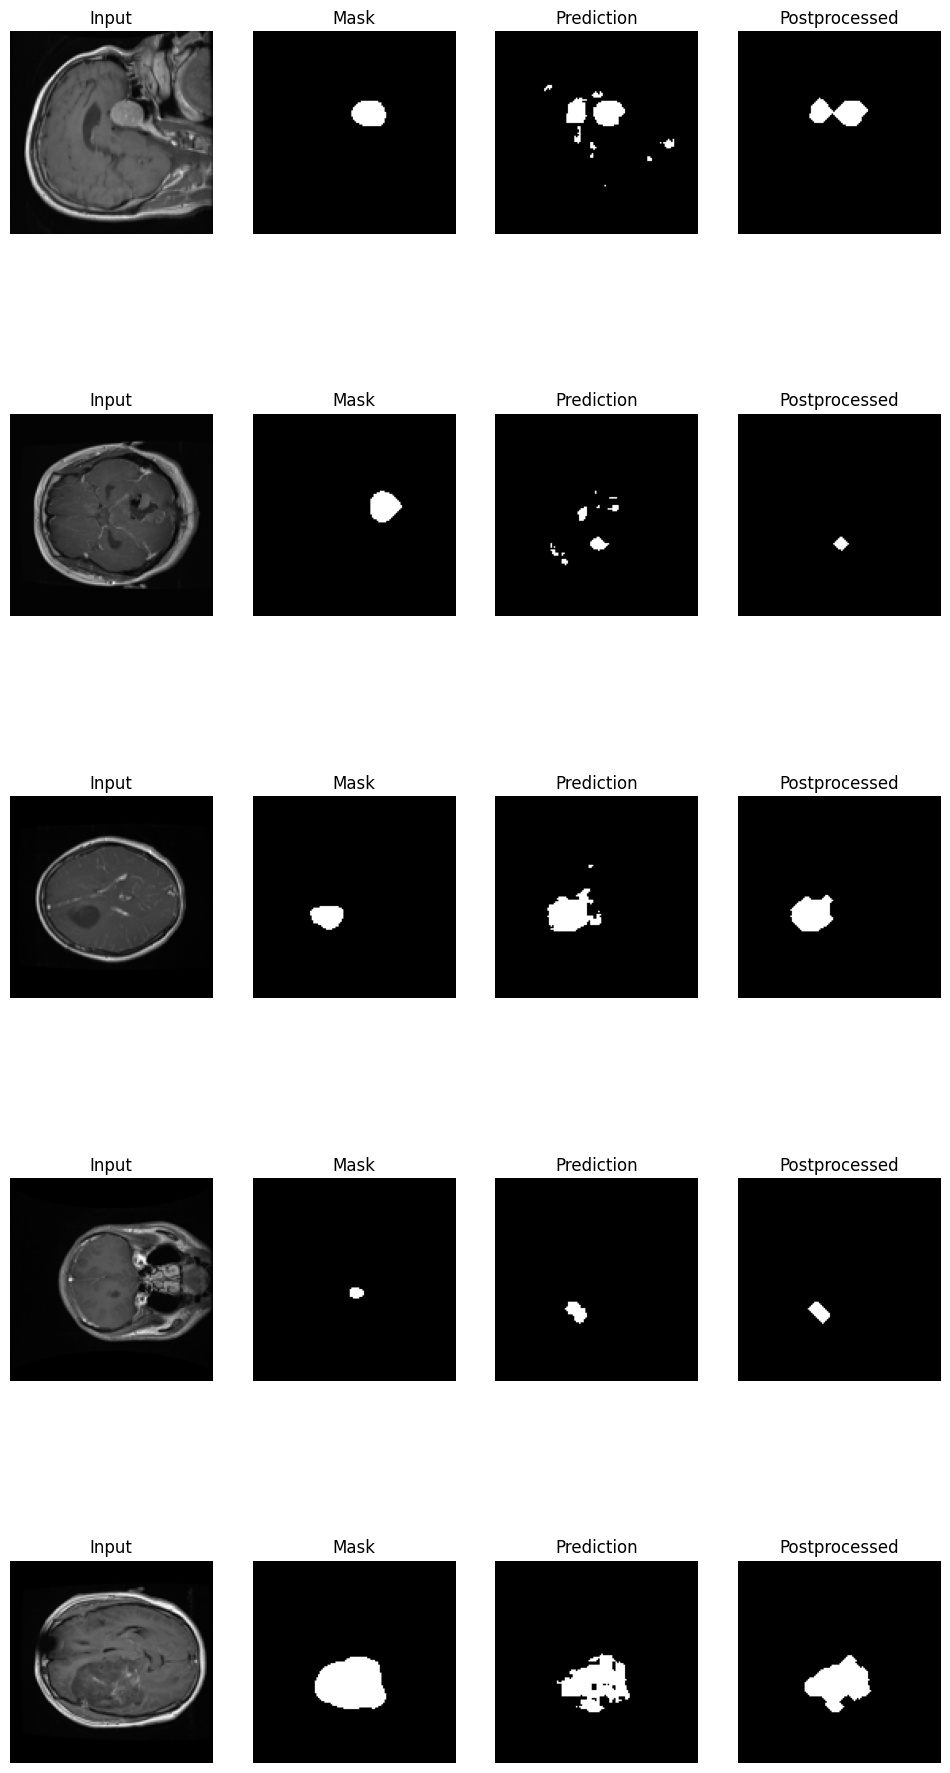

In [ ]:
def post_process(pred_mask):
    """Takes a binary mask and applies simple sequence of morphological postprocessing operations
    """
    kernel = np.array([[0, 1, 0],
                        [1, 1, 1],
                        [0, 1, 0]], dtype=np.uint8)
    # kernel2 = np.array([[0, 0, 1, 0, 0],
    #                     [0, 1, 1, 1, 0],
    #                     [1, 1, 1, 1, 1]
    #                     [0, 1, 1, 1, 0],
    #                     [0, 0, 1, 0, 0]], dtype=np.uint8)
    pred_mask = pred_mask.numpy().astype(np.uint8)
    open = cv2.morphologyEx(pred_mask, cv2.MORPH_OPEN, kernel, iterations=3)
    close = cv2.morphologyEx(open, cv2.MORPH_CLOSE, kernel, iterations=3)
    # erode = cv2.erode(close, kernel, iterations=2)
    # dilate = cv2.dilate(erode, kernel, iterations=2)
    return close

def make_plot_predictions(model: torch.nn.Module, dataset: torch.utils.data.DataLoader, n: int=5, seed: int=None):
    if seed:
        random.seed(seed)
    if n > 5:
        print('Setting n to maximum of 5')
        n = 5

    samples = random.sample(range(len(dataset)), k=n)
    plt.figure(figsize=(12, 24))
    model.eval()
    with torch.inference_mode():
        for i, sample_idx in enumerate(samples):
            image, mask =  dataset[sample_idx][0], dataset[sample_idx][1]
            plt.subplot(n, 4, i * 4 + 1)
            plt.imshow(image.squeeze(), cmap='gray')
            plt.title('Input')
            plt.axis(False)

            plt.subplot(n, 4, i * 4 + 2)
            plt.imshow(mask.squeeze(), cmap='gray')
            plt.title('Mask')
            plt.axis(False)

            plt.subplot(n, 4, i * 4 + 3)
            y_logit = model(image.unsqueeze(0))
            y_pred = y_logit.sigmoid().round()
            plt.imshow(y_pred[0][0], cmap='gray')
            plt.title('Prediction')
            plt.axis(False)

            plt.subplot(n, 4, i * 4 + 4)
            y_processed = post_process(y_pred[0][0])
            plt.imshow(y_processed, cmap='gray')
            plt.title('Postprocessed')
            plt.axis(False)

make_plot_predictions(model=model_2, dataset=test_data)